In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import pandas as pd
import numpy  as np
import math

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch
import torch.nn as nn
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

In [3]:
look_back      = params.look_back_tick 
features_cols  = params.features_cols_tick
label_col      = params.label_col
device         = params.device

# date = dt.datetime.now().strftime("%Y-%m-%d %H:%M")

df_feat = pd.read_csv(params.feat_csv, index_col=0, parse_dates=True)

df_features = df_feat[features_cols + ['signal','ask','bid']]
df_features 

,vol_15,ma_5,ma_20,close,hour,bb_width_20,high,low,open,vwap_dev,atr_14,r_5,r_1,r_15,obv,signal,ask,bid
2004-01-02 13:09:00,-0.966783,-0.185561,-0.282361,-0.193762,0.493,-0.929333,-0.317313,-0.028125,-0.193147,-0.032030,-1.435516,-0.040971,-0.029212,-0.025534,11.535427,0.005593,0.764807,0.763664
2004-01-02 13:10:00,-0.965007,-0.192087,-0.284115,-0.201725,0.493,-0.921566,-0.324262,-0.037500,-0.201085,-0.036171,-1.432540,-0.054390,-0.029213,-0.033477,11.491025,0.006095,0.764790,0.763647
2004-01-02 13:11:00,-0.963779,-0.200245,-0.286307,-0.209688,0.493,-0.913246,-0.331210,-0.046875,-0.209022,-0.040262,-1.429563,-0.067809,-0.029214,-0.041420,11.441197,0.006642,0.764773,0.763631
2004-01-02 13:12:00,-0.963001,-0.208402,-0.288939,-0.217651,0.493,-0.904541,-0.338159,-0.056250,-0.216960,-0.044296,-1.426587,-0.067810,-0.029214,-0.049363,11.385942,0.007239,0.764757,0.763614
2004-01-02 13:13:00,-0.962622,-0.216560,-0.292008,-0.225614,0.493,-0.895592,-0.345107,-0.065625,-0.224897,-0.048268,-1.423611,-0.067812,-0.029215,-0.057307,11.325262,0.007889,0.764740,0.763597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.507307,0.367023,-0.130453,0.705997,-0.939,0.122381,0.704918,0.500000,0.475806,0.407906,2.024482,1.742521,0.837991,1.317936,0.839704,0.000000,196.962600,196.667400
2025-06-18 20:57:00,0.566581,0.460866,-0.093452,0.478780,-0.939,0.187641,0.836066,0.387097,0.685484,0.263954,2.207440,0.887590,-0.939239,1.115397,0.647913,0.000000,196.822500,196.527500
2025-06-18 20:58:00,0.542508,0.497086,-0.060109,0.470665,-0.939,0.241322,0.508197,0.500000,0.467742,0.254269,2.216153,0.341995,-0.033854,0.828890,0.429218,0.000000,196.817500,196.522500
2025-06-18 20:59:00,0.903328,0.408182,-0.062549,-0.227217,-0.939,0.245429,0.524590,-0.129032,0.475806,-0.173638,2.487280,-0.842944,-2.888426,-0.094079,-0.434952,0.043551,196.387200,196.092800


In [4]:
X, y, raw_close, raw_bid, raw_ask = models.build_lstm_tensors(
    df=df_features,
    look_back=look_back,
    features_cols=features_cols,
    label_col=label_col,
    sess_start = False # if we want the predictions not to start from sess_start, but from sess_start_pred
)

# quick shapes
print("Shapes:")
print("  X         =", X.shape,    "(samples, look_back, features)")
print("  y         =", y.shape,    "(samples,)")
print("  raw_close =", raw_close.shape)
print("  raw_bid   =", raw_bid.shape)
print("  raw_ask   =", raw_ask.shape)


Counting valid windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Shapes:
  X         = torch.Size([2270503, 30, 15]) (samples, look_back, features)
  y         = torch.Size([2270503]) (samples,)
  raw_close = torch.Size([2270503])
  raw_bid   = torch.Size([2270503])
  raw_ask   = torch.Size([2270503])


In [5]:
# Split into train/val/test by calendar day
(X_tr, y_tr), \
(X_val, y_val), \
(X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
samples_per_day, day_id_tr, day_id_val, day_id_te = models.chronological_split(
    X, y, raw_close, raw_bid, raw_ask, df_features,
    look_back   = look_back,
    train_prop  = params.train_prop,
    val_prop    = params.val_prop,
    train_batch = params.hparams['TRAIN_BATCH'],
    sess_start  = False # if we want the predictions not to start from sess_start, but from sess_start_pred

)

# Print shapes of all tensors
print("Shapes:")
print("  X_tr  =", X_tr.shape)
print("  y_tr  =", y_tr.shape)
print("  X_val =", X_val.shape)
print("  y_val =", y_val.shape)
print("  X_te  =", X_te.shape)
print("  y_te  =", y_te.shape)


Shapes:
  X_tr  = torch.Size([1593707, 30, 15])
  y_tr  = torch.Size([1593707])
  X_val = torch.Size([336375, 30, 15])
  y_val = torch.Size([336375])
  X_te  = torch.Size([340421, 30, 15])
  y_te  = torch.Size([340421])


In [6]:
# -----------------------------------------------------------------------------
#  Build DataLoaders over calendar‐days
# -----------------------------------------------------------------------------
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # Training split arrays (from chronological_split)
    X_tr, y_tr, day_id_tr,
    # Validation split arrays
    X_val, y_val, day_id_val,
    # Test split arrays + raw prices for post‐tracking
    X_te, y_te, day_id_te, raw_close_te, raw_bid_te, raw_ask_te,
    # Original minute‐bar DataFrame for weekday mapping
    df=df_features,
    train_batch=params.hparams['TRAIN_BATCH'],
    train_workers=params.hparams['NUM_WORKERS'],
    train_prefetch_factor=params.hparams['TRAIN_PREFETCH_FACTOR']
)


▶️ Entered split_to_day_datasets
1) building weekday arrays
   Weekdays counts → tr=1593707, val=336375, te=340421
2) moving all splits to CPU
   CPU casts done
3) zero-bas­ing day_id for val & test
   val_day_id ∈ [0..798], total days=799
   te_day_id  ∈ [0..808], total days=809
4) instantiating DayWindowDatasets
   ds_tr days: 3792
   ds_val days: 799
   ds_te days: 809
5) building DataLoaders
   train_loader ready
   val_loader ready
   test_loader ready


In [7]:
# -----------------------------------------------------------------------------
# Instantiate the stateful DualMemoryLSTM & move to device
# -----------------------------------------------------------------------------
model = models.DualMemoryLSTM(
    n_feats        = len(features_cols),                          
    short_units    = params.hparams['SHORT_UNITS'],    
    long_units     = params.hparams['LONG_UNITS'],     
    dropout_short  = params.hparams['DROPOUT_SHORT'],  
    dropout_long   = params.hparams['DROPOUT_LONG'],   
    att_heads      = params.hparams['ATT_HEADS'],
    att_drop       = params.hparams['ATT_DROPOUT']
)
model.to(device)   # place model parameters on GPU or CPU as specified

model

DualMemoryLSTM(
  (conv): Conv1d(15, 15, kernel_size=(3,), stride=(1,), padding=(1,))
  (short_lstm): LSTM(15, 64, batch_first=True, bidirectional=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (do_short): Dropout(p=0.1, inplace=False)
  (ln_short): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(128, 64, batch_first=True, bidirectional=True)
  (do_long): Dropout(p=0.1, inplace=False)
  (ln_long): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=128, out_features=1, bias=True)
  (cls_head): Linear(in_features=128, out_features=1, bias=True)
)

In [8]:
# -----------------------------------------------------------------------------
# Compute plateau_sched timing parameters
# -----------------------------------------------------------------------------
# Total training samples = total windows in X_tr (one window per row)
n_train_samples = X_tr.shape[0]

# How many optimizer steps (day‐bundles) constitute one epoch?
steps_per_epoch = len(train_loader)


# -----------------------------------------------------------------------------
# Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm
# -----------------------------------------------------------------------------
optimizer, plateau_sched, cosine_sched, scaler, clipnorm = models.make_optimizer_and_scheduler(
    model,
    initial_lr        = params.hparams['INITIAL_LR'],       
    weight_decay      = params.hparams['WEIGHT_DECAY'],     
    clipnorm          = params.hparams['CLIPNORM']   
)

optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 1e-05
)

In [9]:
# -----------------------------------------------------------------------------
# Count how many calendar days we see each epoch and Compute baseline RMSE on validation (zero forecast)
# -----------------------------------------------------------------------------
n_train_days = len(train_loader.dataset)  # dataset length = # unique days
print(f"Training sees {n_train_days} calendar days per epoch\n")

baseline_val_rmse = models.naive_rmse(val_loader)
print(f"Baseline (zero‐forecast) RMSE on validation = {baseline_val_rmse:.6f}")

Training sees 3792 calendar days per epoch

Baseline (zero‐forecast) RMSE on validation = 0.285192


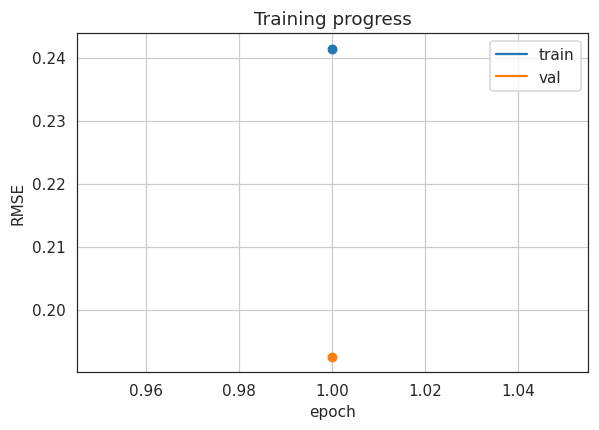

Epoch 1:   0%|          | 0/237 [00:00<?, ?bundle/s]

Epoch 001 • train_rmse=0.2414 • train_acc=0.8077 • val_rmse=0.1925 • val_acc=0.8224  • lr=1.00e-03


Epoch 2:   0%|          | 0/237 [00:00<?, ?bundle/s]

KeyboardInterrupt: 

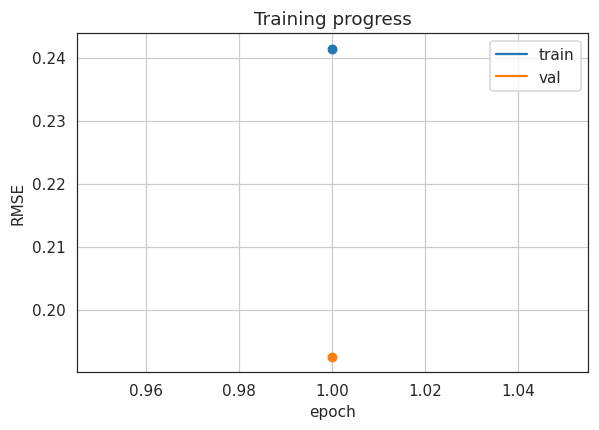

In [10]:
# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = models.custom_stateful_training_loop(
    model               = model,
    optimizer           = optimizer,
    cosine_sched        = cosine_sched,
    plateau_sched       = plateau_sched,
    scaler              = scaler,
    train_loader        = train_loader,
    val_loader          = val_loader,
    max_epochs          = params.hparams['MAX_EPOCHS'],
    early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
    baseline_val_rmse   = baseline_val_rmse,
    clipnorm            = clipnorm,
    device              = device
)

# -----------------------------------------------------------------------------
# Final reporting: best RMSE and relative improvement
# -----------------------------------------------------------------------------
print(f"\nChampion validation RMSE = {best_val_rmse:.6f}")

improvement = 100.0 * (1.0 - best_val_rmse / baseline_val_rmse)
print(f"Improvement over zero‐baseline = {improvement:5.1f}%")
